In [1]:
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastai.tabular.all as fai_tab
import torch
from torch.utils.data import Dataset, DataLoader

pd.options.display.max_columns = 0

In [2]:
from kaggle import api

comp = "bluebook-for-bulldozers"
path = Path(f"./datasets/{comp}")

if not path.exists():
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))
    (path/f'{comp}.zip').unlink()

100%|██████████| 48.4M/48.4M [00:08<00:00, 6.23MB/s]


In [54]:
df_raw = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [55]:
def clean_data(df: pd.DataFrame):
    data = df.copy()
    data = data.sort_values(by='saledate', ascending=True)

    """
    fiModelDesc is just the combination of fiBaseModel, fiSecondaryDesc, 
    fiModelSeries, and fiModelDescriptor. Richer information is likely to be 
    extracted when using them individually, so we won't use fiModelDesc.
    """
    data = data.drop(['fiModelDesc'], axis=1)

    """
    Many of the latter columns have "None or Unspecified" listed instead of "blank",
    where the two seem to be functionally the same. To maintain consistency, 
    we will make "None or Unspecified" blank.
    """
    data.replace('None or Unspecified', np.nan, inplace=True)

    """
    fiProductClassDesc contains the ProductGroupDesc as well as a descriptor of 
    the "primary size basis" and the range of the size (when present). 
    The size basis and range can be dropped from the product group desc by 
    removing all up to the first " - ". 
    """
    data['sizeBasis'] = (data['fiProductClassDesc']
        .str.replace(r'.* - ', '', regex=True)
    )
    data = data.drop('fiProductClassDesc', axis=1)

    # ProductGroup is just ProductGroupDesc abbreviated
    data = data.drop('ProductGroup', axis=1)

    # Create date columns
    data['saledate'] = pd.to_datetime(data['saledate'])
    data['saleyear'] = data['saledate'].dt.year
    data['salemonth'] = data['saledate'].dt.month
    data['saleday'] = data['saledate'].dt.day
    data['saledayofweek'] = data['saledate'].dt.day_of_week
    data = data.drop('saledate', axis=1)

    # Make sure tire size is consistent (some have " other inch) and make it a float
    data['Tire_Size'] = pd.to_numeric(
        data['Tire_Size'].str.replace('"', '', regex=True)
            .str.replace(' inch', '', regex=True)
    )

    # Convert stick length to inches
    data['Stick_Length'] = (
        pd.to_numeric(data['Stick_Length'].str.split("'").str[0]) * 12 \
            + pd.to_numeric(data['Stick_Length'].str.split("'").str[1].replace('"', '', regex=True)
                .str.strip())
    )

    # Undercarriage_Pad_Width to int
    data['Undercarriage_Pad_Width'] = pd.to_numeric(
        data['Undercarriage_Pad_Width'].str.replace(' inch', '', regex=True)
    )

    # Drop unique id columns
    data = data.drop('SalesID', axis=1)
    data = data.drop('MachineID', axis=1)
    
    return data

In [56]:
def fill_and_transform_categorical(
        df: pd.DataFrame,
        high_ordinality_threshold: int = 10,
        numeric_cat_cols: list[str] = None,
        cat_ordered_cols: dict[str, list[str]] = None
) -> pd.DataFrame:
    """
    Fill missing data, creating a column indicating if filled. Apply transformations to
    categorical columns, one hot encoding if low cardinality, else categorical codes.
    Apply specified order to columns with inherent order. 
    :param df: 
    :param high_ordinality_threshold: 
    :param numeric_cat_cols: Numerical columns that are actually categories (e.g. class Ids, etc.) 
    :param cat_ordered_cols: dict of column name and the list of categories, in order.
    :return: Copy of df, filled and transformed 
    """
    transformed_df = df.copy()
    
    for col in transformed_df.columns:
        if cat_ordered_cols and col in cat_ordered_cols:
            transformed_df[col] = pd.Categorical(
                transformed_df[col],
                categories=cat_ordered_cols[col],
                ordered=True
            ).codes + 1
        if (not pd.api.types.is_numeric_dtype(transformed_df[col]) or 
                numeric_cat_cols and col in numeric_cat_cols):
            high_cardinality = transformed_df[col].nunique() > high_ordinality_threshold
            if high_cardinality:
                transformed_df[col] = transformed_df[col].astype('category').cat.codes + 1
            else:
                # One hot encodes columns (also removes the original cols)
                transformed_df = pd.get_dummies(transformed_df, dummy_na=True, columns=[col])
                
    return transformed_df

def fill_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fill missing numeric data with median and add a column indicating if each was missing. 
    :param df: 
    :return: Copy of df, filled
    """
    filled_df = df.copy()
    for col in filled_df.columns:
        if pd.api.types.is_numeric_dtype(filled_df[col]):
            if pd.isnull(filled_df[col]).sum():
                filled_df[col + '_na'] = pd.isnull(filled_df[col])
                filled_df[col] = filled_df[col].fillna(filled_df[col].median())
                
    return filled_df

def normalize(
    df: pd.DataFrame,
    exclude_cols: list[str] | None = None,
    log_cols: list[str] | None = None
) -> pd.DataFrame:
    if not exclude_cols:
        exclude_cols = []
    if not log_cols:
        log_cols = []

    norm_df = df.copy()
    for col, max in df.max().sort_values(ascending=False).items():
        if col in exclude_cols:
            continue
        if col in log_cols:
            norm_df[col] = np.log(norm_df[col] + 1)
        if max > 1:
            norm_df[col] = norm_df[col] / norm_df[col].max()

    return norm_df

In [57]:
df = clean_data(df_raw)
df = fill_and_transform_categorical(df)
df = fill_numeric(df)
df = normalize(df, exclude_cols=['SalePrice'])

In [58]:
df.describe()

,SalePrice,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,state,Hydraulics,Tire_Size,Undercarriage_Pad_Width,Stick_Length,sizeBasis,saleyear,salemonth,saleday,saledayofweek
count,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000
mean,31215.181414,0.186763,0.781326,0.064258,0.942924,0.000507,0.287247,0.214062,0.075217,0.088684,0.442509,0.361982,0.694203,0.776781,0.399492,0.433190,0.996182,0.525022,0.521061,0.432390
std,23141.743695,0.168848,0.055762,0.169330,0.145080,0.006576,0.241305,0.220377,0.220313,0.209414,0.296798,0.397969,0.052544,0.035276,0.011243,0.247425,0.002893,0.286440,0.271920,0.236328
min,4750.000000,0.000753,0.699422,0.000000,0.496524,0.000000,0.000510,0.000000,0.000000,0.000000,0.018868,0.000000,0.237288,0.388889,0.257732,0.014493,0.988569,0.083333,0.032258,0.000000
25%,14500.000000,0.087666,0.763006,0.010101,0.985601,0.000000,0.106068,0.000000,0.000000,0.000000,0.169811,0.090909,0.694915,0.777778,0.398625,0.246377,0.994036,0.250000,0.290323,0.333333
50%,24000.000000,0.123797,0.763006,0.020202,0.990566,0.000000,0.208057,0.175141,0.000000,0.000000,0.396226,0.090909,0.694915,0.777778,0.398625,0.376812,0.997018,0.500000,0.516129,0.500000
75%,40000.000000,0.239233,0.786127,0.040404,0.993545,0.000000,0.360020,0.333333,0.000000,0.000000,0.773585,1.000000,0.694915,0.777778,0.398625,0.594203,0.998509,0.750000,0.741935,0.500000
max,142000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
class BulldozerDataset(Dataset):
    def __init__(self, df):
        self.label_col = 'SalePrice'
        self.df = df.copy().astype('float32')

        self.df_X = torch.from_numpy(self.df.copy().drop(self.label_col, axis=1).values).float()
        self.df_y = torch.from_numpy(self.df.copy()[self.label_col].values).float()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df_X[idx], self.df_y[idx]

In [67]:
def split_data(full: pd.DataFrame, valid_ratio=0.2):
    train_len = round(len(full) * (1-valid_ratio))

    train = full.iloc[:train_len, :]
    valid = full.iloc[train_len+1:, :]

    return train, valid

In [75]:
train_split, val_split = split_data(df)

ds_train = BulldozerDataset(train_split)
ds_val = BulldozerDataset(val_split)

In [76]:
ds_train[0]

(tensor([0.7249, 1.0000, 1.0000, 0.9911, 0.0000, 0.3626, 0.2825, 0.4553, 0.0000,
         0.4151, 0.0909, 0.6949, 0.7778, 0.3986, 0.4493, 1.0000, 0.0833, 0.0323,
         1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 1.0

In [80]:
train_dataloader = DataLoader(ds_train, batch_size=1024)
val_dataloader = DataLoader(ds_val, batch_size=1024)

In [87]:
class SigmoidRangeLayer(torch.nn.Module):
    def __init__(self, low, high):
        super().__init__()
        self.low = low
        self.high = high
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(x) * (self.high - self.low) + self.low

tensor(0.)


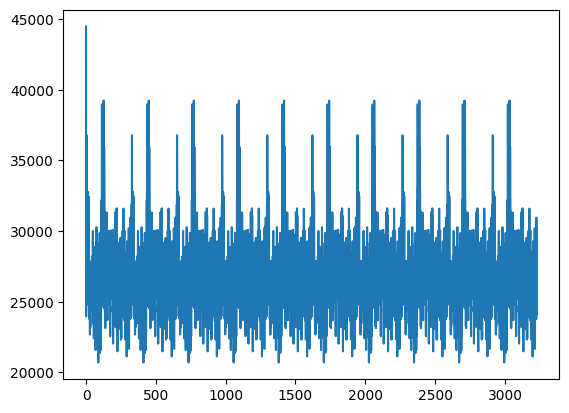

In [101]:
# All but the target column are features
num_features = len(df.columns) - 1
epochs = 10

# More or less replicates fastai's 10, 10, but they seem to have other stuff
# I don't know about yet, like BatchNorm1d and Dropout in addition to  Linear
# So performance will probably be worse, but fine for now
model = torch.nn.Sequential(
    torch.nn.Linear(num_features, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 250),
    torch.nn.ReLU(),
    torch.nn.Linear(250, 1),
    SigmoidRangeLayer(df['SalePrice'].min(), df['SalePrice'].max())
)

# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.L1Loss()
optim = torch.optim.SGD(model.parameters(), lr=0.01)

accs = []
losses = []
def train_loop(Xb: torch.Tensor, yb: torch.Tensor):
    preds = model(Xb)
    # loss = loss_fn(preds, yb)
    loss = loss_fn(preds, yb.float().view(-1,1))

    loss.backward()
    optim.step()
    optim.zero_grad()

    losses.append(loss.item())

    return loss.item()

def valid_loop(Xb: torch.Tensor, yb: torch.Tensor):
    preds = model(Xb)
    # loss = loss_fn(preds, yb)
    loss = loss_fn(preds, yb.view(-1,1))
    acc = ((preds > 0.5) == yb).float().mean()
    return loss, acc


for epoch in range(epochs):
    model.train()
    for Xb, yb in train_dataloader:
        loss = train_loop(Xb, yb)
    
    # model.eval()
    # with torch.inference_mode():
    #     for Xb, yb in val_dataloader:
    #         loss, acc = valid_loop(Xb, yb)
        
    # losses.append(loss)
    # accs.append(acc)

plt.plot(losses)
print(acc)

In [100]:
losses

[45949.109375,
 23957.861328125,
 25278.466796875,
 30645.140625,
 31883.203125,
 28331.640625,
 36779.29296875,
 31577.783203125,
 27628.564453125,
 27467.697265625,
 29948.876953125,
 25135.498046875,
 24807.861328125,
 32775.78125,
 27017.67578125,
 26590.771484375,
 27067.08984375,
 29073.779296875,
 32458.447265625,
 28517.041015625,
 25895.751953125,
 27913.451171875,
 25206.591796875,
 26345.8984375,
 23781.4453125,
 26554.736328125,
 23812.158203125,
 25151.734375,
 22683.203125,
 25911.1328125,
 25799.951171875,
 23196.38671875,
 27706.15234375,
 24342.626953125,
 24776.318359375,
 27071.240234375,
 24867.236328125,
 27886.9140625,
 26533.69140625,
 24975.390625,
 26348.779296875,
 25042.96875,
 26844.140625,
 26929.4921875,
 24738.037109375,
 28226.025390625,
 27661.5234375,
 26322.705078125,
 26340.771484375,
 30006.93359375,
 23471.068359375,
 26606.884765625,
 25849.853515625,
 24538.232421875,
 26139.794921875,
 24526.90625,
 22418.1640625,
 25678.80859375,
 26962.2558593